In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/public_data_test/track_c/test/ind.csv
/kaggle/input/public_data_test/track_c/test/tat.csv
/kaggle/input/public_data_test/track_c/test/swe.csv
/kaggle/input/public_data_test/track_c/test/afr.csv
/kaggle/input/public_data_test/track_c/test/xho.csv
/kaggle/input/public_data_test/track_c/test/amh.csv
/kaggle/input/public_data_test/track_c/test/ptbr.csv
/kaggle/input/public_data_test/track_c/test/mar.csv
/kaggle/input/public_data_test/track_c/test/eng.csv
/kaggle/input/public_data_test/track_c/test/yor.csv
/kaggle/input/public_data_test/track_c/test/hau.csv
/kaggle/input/public_data_test/track_c/test/som.csv
/kaggle/input/public_data_test/track_c/test/ron.csv
/kaggle/input/public_data_test/track_c/test/zul.csv
/kaggle/input/public_data_test/track_c/test/sun.csv
/kaggle/input/public_data_test/track_c/test/arq.csv
/kaggle/input/public_data_test/track_c/test/hin.csv
/kaggle/input/public_data_test/track_c/test/ibo.csv
/kaggle/input/public_data_test/track_c/test/chn.csv
/kaggle/inp

# Install Libraries and Modules

In [2]:
import warnings
warnings.filterwarnings('ignore') 

In [3]:
!pip uninstall -y wandb

Found existing installation: wandb 0.19.1
Uninstalling wandb-0.19.1:
  Successfully uninstalled wandb-0.19.1


In [4]:
!pip install wandb==0.17.5 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 51.0 MB/s eta 0:00:0000:0100:01


In [5]:
import wandb

In [6]:
!wandb offline
!wandb disabled

W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.
W&B disabled.


In [7]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [8]:
!pip install datasets transformers evaluate sentencepiece accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.9 MB/s eta 0:00:0000:01


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from transformers import AutoTokenizer, XLMRobertaTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

import torch
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [32]:
train_hin = pd.read_csv("/kaggle/input/public_data_test/track_a/train/hin.csv")
train_swe = pd.read_csv("/kaggle/input/public_data_test/track_a/train/swe.csv")


dev_hin = pd.read_csv("/kaggle/input/public_data_test/track_a/dev/hin.csv")
dev_swe = pd.read_csv("/kaggle/input/public_data_test/track_a/dev/swe.csv")


test_hin = pd.read_csv("/kaggle/input/public_data_test/track_a/test/hin.csv")
test_swe = pd.read_csv("/kaggle/input/public_data_test/track_a/test/swe.csv")

# Hindi

## Sources:
- https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment
- https://huggingface.co/microsoft/Multilingual-MiniLM-L12-H384
- https://huggingface.co/google-bert/bert-base-multilingual-cased
- https://huggingface.co/FacebookAI/xlm-roberta-base

In [11]:
train_hin.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,hin_train_track_a_00001,वह अपने दोस्तों के साथ मूवी देखने गई थी।,0,0,0,0,0,0
1,hin_train_track_a_00002,ऑफिस की फाइल्स ठीक से रखी गई हैं।,0,0,0,0,0,0
2,hin_train_track_a_00003,युद्ध के प्रभाव से सीमावर्ती क्षेत्रों में खाद...,0,0,0,0,0,0
3,hin_train_track_a_00004,अरे वाह! आज तो मेरी बेटी ने अपने कमरे की ही नह...,0,0,0,1,0,1
4,hin_train_track_a_00005,गवर्नमेंट की नई टैक्स योजना ने तो गरीबों को और...,1,0,0,0,1,0


In [12]:
train_hin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2556 non-null   object
 1   text      2556 non-null   object
 2   anger     2556 non-null   int64 
 3   disgust   2556 non-null   int64 
 4   fear      2556 non-null   int64 
 5   joy       2556 non-null   int64 
 6   sadness   2556 non-null   int64 
 7   surprise  2556 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 159.9+ KB


In [13]:
dev_hin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        100 non-null    object
 1   text      100 non-null    object
 2   anger     100 non-null    int64 
 3   disgust   100 non-null    int64 
 4   fear      100 non-null    int64 
 5   joy       100 non-null    int64 
 6   sadness   100 non-null    int64 
 7   surprise  100 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 6.4+ KB


<Axes: >

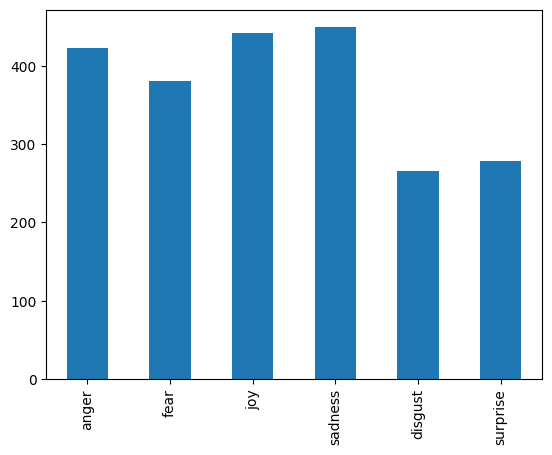

In [14]:
attributes = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise']
train_hin[attributes].sum().plot.bar()

<Axes: >

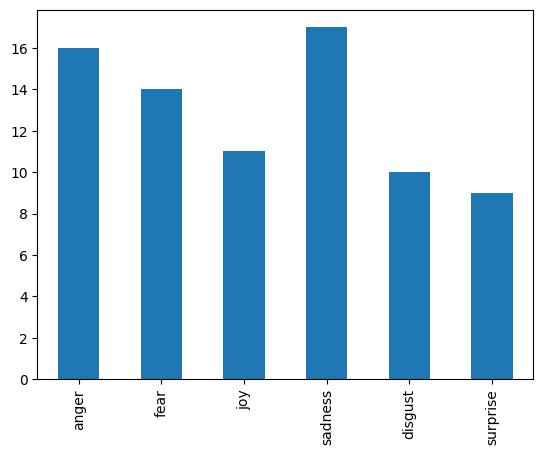

In [15]:
dev_hin[attributes].sum().plot.bar()

In [16]:
test_hin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        1010 non-null   object 
 1   text      1010 non-null   object 
 2   anger     0 non-null      float64
 3   disgust   0 non-null      float64
 4   fear      0 non-null      float64
 5   joy       0 non-null      float64
 6   sadness   0 non-null      float64
 7   surprise  0 non-null      float64
dtypes: float64(6), object(2)
memory usage: 63.2+ KB


In [17]:
test_hin.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,hin_test_track_a_00001,ट्रेन में अचानक धमाका हुआ और फिर चारों तरफ अफर...,NaN,NaN,NaN,NaN,NaN,NaN
1,hin_test_track_a_00002,पोलिटिकल स्कैंडल्स और भ्रष्टाचार की घटनाओं से ...,NaN,NaN,NaN,NaN,NaN,NaN
2,hin_test_track_a_00003,लिखती तो हूँ लेकिन रिजेक्शन के डर से कभी अपनी ...,NaN,NaN,NaN,NaN,NaN,NaN
3,hin_test_track_a_00004,इतना बड़ा भ्रष्टाचार का मामला सामने आया है कि ...,NaN,NaN,NaN,NaN,NaN,NaN
4,hin_test_track_a_00005,राजनीतिज्ञों द्वारा मुफ्त सेवाओं का उपयोग करना...,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
emotion_labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]

# Multilingual MiniLM L12 H384 

In [21]:
# Load tokenizer and model
tokenizer = XLMRobertaTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384',
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# Tokenizer function
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)

In [34]:
# Encode datasets
def encode_data(df, tokenizer):
    encodings = tokenizer(list(df['text']), truncation=True, padding=True, max_length=128)
    labels = df[emotion_labels].fillna(0).values
    return encodings, labels

In [35]:
train_encodings, train_labels = encode_data(train_hin, tokenizer)
dev_encodings, dev_labels = encode_data(dev_hin, tokenizer)

In [36]:
# Custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

In [37]:
train_dataset = CustomDataset(train_encodings, train_labels)
dev_dataset = CustomDataset(dev_encodings, dev_labels)

In [21]:
train_dataset

In [ ]:
train_dataset.encodings

In [22]:
def calculate_token_lengths(texts, tokenizer):
    token_lengths = [len(tokenizer.encode(text, truncation=False)) for text in texts]
    return token_lengths

# Calculate token lengths for your datasets
train_lengths = calculate_token_lengths(train_hin['text'], tokenizer)
dev_lengths = calculate_token_lengths(dev_hin['text'], tokenizer)
test_lengths = calculate_token_lengths(test_hin['text'], tokenizer)

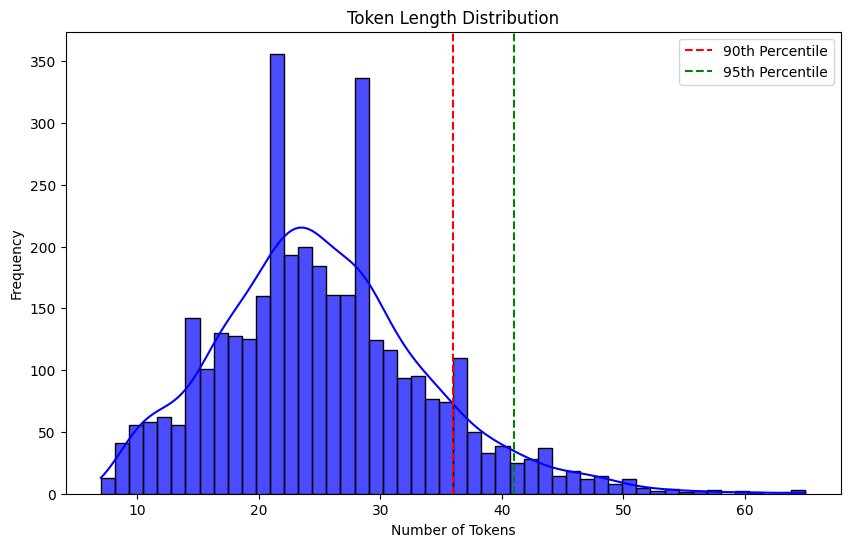

In [23]:
# Combine lengths from all datasets for a global view
all_lengths = train_lengths + dev_lengths + test_lengths

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(all_lengths, bins=50, kde=True, color='blue', alpha=0.7)
plt.axvline(x=np.percentile(all_lengths, 90), color='red', linestyle='--', label='90th Percentile')
plt.axvline(x=np.percentile(all_lengths, 95), color='green', linestyle='--', label='95th Percentile')
plt.title('Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [18]:
# Metrics
def compute_metrics(pred, threshold=0.3):
    logits, labels = pred
    predictions = (torch.sigmoid(torch.tensor(logits)) > threshold).numpy()
    labels = labels.astype(int)

    # Per-class metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': np.mean(f1),
        'precision': np.mean(precision),
        'recall': np.mean(recall),
    }


In [31]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results/hin/mMiniLM-L12xH384-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [32]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [19]:
from unittest import mock
from unittest.mock import Mock
class Dummy:
    def __enter__(self):
        return Mock()

    def __exit__(self, *args):
        pass

In [34]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.430600,0.391102,0.310000,0.000000,0.000000,0.000000
1000,0.356800,0.326703,0.520000,0.493754,0.461799,0.571429
1500,0.283900,0.275292,0.550000,0.656385,0.572873,0.779221
2000,0.230400,0.252033,0.560000,0.643476,0.586801,0.727273
2500,0.187100,0.229900,0.590000,0.653028,0.619098,0.727273
3000,0.153400,0.221804,0.700000,0.704328,0.724231,0.714286
3500,0.124400,0.212316,0.670000,0.695509,0.674003,0.740260
4000,0.102400,0.207972,0.640000,0.695361,0.641320,0.766234
4500,0.080700,0.217684,0.680000,0.711563,0.690430,0.753247
5000,0.066900,0.211129,0.650000,0.707990,0.659128,0.779221


In [38]:
# Function to find the optimal threshold
def find_best_threshold(pred, thresholds):
    best_threshold = 0.5
    best_f1 = 0
    
    for t in thresholds:
        metrics = compute_metrics(pred, threshold=t)
        print(f"metrics: {metrics}")
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_threshold = t

    return best_threshold, best_f1

In [39]:
# Validation step
def evaluate_on_validation_set(trainer, threshold_range=np.linspace(0.1, 0.9, 9)):
    # Run predictions on the validation set
    predictions, labels, _ = trainer.predict(dev_dataset)  # Ensure dev_dataset is defined
    pred = (predictions, labels)

    # Find the best threshold
    best_threshold, best_f1 = find_best_threshold(pred, thresholds=threshold_range)
    print("----------------------------------------------")
    print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1:.4f}")
    print("***********************************************")
    # Evaluate using the best threshold
    final_metrics = compute_metrics(pred, threshold=best_threshold)
    print(f"Metrics with Best Threshold: {final_metrics}")

    return best_threshold, final_metrics

In [37]:
best_threshold, final_metrics = evaluate_on_validation_set(trainer)
print(f"Optimal Threshold: {best_threshold}")
print(f"Final Metrics: {final_metrics}")

metrics: {'accuracy': 0.52, 'f1': 0.6404452690166976, 'precision': 0.5151601645108139, 'recall': 0.8571428571428571}
metrics: {'accuracy': 0.57, 'f1': 0.6792499360557437, 'precision': 0.5951917957265551, 'recall': 0.8051948051948052}
metrics: {'accuracy': 0.64, 'f1': 0.6953613486081018, 'precision': 0.6413197249321652, 'recall': 0.7662337662337663}
metrics: {'accuracy': 0.67, 'f1': 0.7213930009384555, 'precision': 0.6878755083300537, 'recall': 0.7662337662337663}
metrics: {'accuracy': 0.72, 'f1': 0.7272909032890883, 'precision': 0.7343706798252253, 'recall': 0.7402597402597403}
metrics: {'accuracy': 0.71, 'f1': 0.7203993428371565, 'precision': 0.7563197264495967, 'recall': 0.7142857142857143}
metrics: {'accuracy': 0.72, 'f1': 0.7297575771953908, 'precision': 0.7875160553731982, 'recall': 0.7012987012987013}
metrics: {'accuracy': 0.69, 'f1': 0.6362419753373627, 'precision': 0.8281385281385282, 'recall': 0.5714285714285714}
metrics: {'accuracy': 0.4, 'f1': 0.20337016784385203, 'precision

In [38]:
# Evaluate on dev set
dev_results = trainer.predict(dev_dataset)

# Plot confusion matrix
predictions = (torch.sigmoid(torch.tensor(dev_results.predictions)) > 0.7).numpy()
conf_matrix = confusion_matrix(dev_labels.ravel(), predictions.ravel())

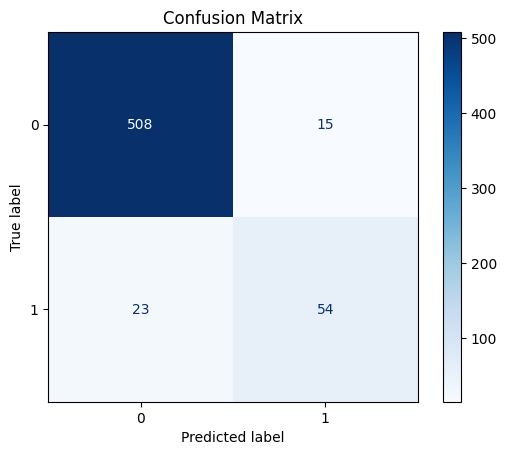

In [39]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

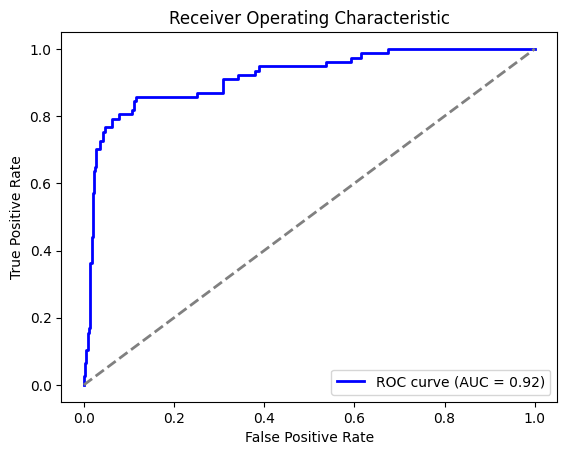

In [40]:
# ROC curve and AUC
fpr, tpr, _ = roc_curve(dev_labels.ravel(), dev_results.predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [41]:
# Print metrics for each class
precision, recall, f1, _ = precision_recall_fscore_support(
    dev_labels, predictions, average=None
)
accuracy = accuracy_score(dev_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
for i, label in enumerate(emotion_labels):
    print(f"{label}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

Accuracy: 0.7200
anger: Precision=0.9231, Recall=0.7500, F1=0.8276
disgust: Precision=0.8571, Recall=0.6000, F1=0.7059
fear: Precision=0.8125, Recall=0.9286, F1=0.8667
joy: Precision=0.5385, Recall=0.6364, F1=0.5833
sadness: Precision=0.7000, Recall=0.4118, F1=0.5185
surprise: Precision=0.9000, Recall=1.0000, F1=0.9474


In [42]:
# Predict on test set
test_encodings = tokenizer(list(test_hin['text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_hin), 6)))  # Dummy labels for test
test_results = trainer.predict(test_dataset)
test_predictions = (torch.sigmoid(torch.tensor(test_results.predictions)) > 0.7).numpy()

In [44]:
# Save predictions
test_hin[emotion_labels] = test_predictions
test_hin.to_csv('test_predictions_hin_mMiniLM-L12xH384_v1.csv', index=False)

In [45]:
test_hin.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,hin_test_track_a_00001,ट्रेन में अचानक धमाका हुआ और फिर चारों तरफ अफर...,False,False,True,False,False,False
1,hin_test_track_a_00002,पोलिटिकल स्कैंडल्स और भ्रष्टाचार की घटनाओं से ...,False,False,False,False,True,False
2,hin_test_track_a_00003,लिखती तो हूँ लेकिन रिजेक्शन के डर से कभी अपनी ...,False,False,True,False,False,False
3,hin_test_track_a_00004,इतना बड़ा भ्रष्टाचार का मामला सामने आया है कि ...,False,False,False,False,False,True
4,hin_test_track_a_00005,राजनीतिज्ञों द्वारा मुफ्त सेवाओं का उपयोग करना...,True,False,False,False,False,False


# BERT Base Multilingual Cased

In [12]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-multilingual-cased')
model = AutoModelForSequenceClassification.from_pretrained('google-bert/bert-base-multilingual-cased',
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results/hin/bert-base-multi-cased-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [23]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [24]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.254800,0.243796,0.550000,0.602731,0.564541,0.662338
1000,0.123300,0.217383,0.650000,0.673780,0.713688,0.675325
1500,0.068600,0.250174,0.670000,0.667149,0.710819,0.675325
2000,0.040900,0.265284,0.640000,0.648958,0.670159,0.649351
2500,0.028200,0.296105,0.620000,0.690201,0.657055,0.753247
3000,0.018900,0.338009,0.660000,0.701100,0.672401,0.753247
3500,0.012100,0.393771,0.610000,0.659613,0.627272,0.727273
4000,0.007700,0.356664,0.620000,0.656812,0.609812,0.727273
4500,0.005500,0.412563,0.660000,0.697695,0.708764,0.714286
5000,0.003900,0.475457,0.630000,0.626987,0.628844,0.662338


In [25]:
best_threshold, final_metrics = evaluate_on_validation_set(trainer)
print(f"Optimal Threshold: {best_threshold}")
print(f"Final Metrics: {final_metrics}")

metrics: {'accuracy': 0.53, 'f1': 0.6853802182029837, 'precision': 0.6077741702741704, 'recall': 0.8181818181818182}
metrics: {'accuracy': 0.6, 'f1': 0.6495244008119063, 'precision': 0.6447301955323346, 'recall': 0.6883116883116883}
metrics: {'accuracy': 0.65, 'f1': 0.6737804221297045, 'precision': 0.71368833187015, 'recall': 0.6753246753246753}
metrics: {'accuracy': 0.65, 'f1': 0.6770626745996204, 'precision': 0.7399010080828263, 'recall': 0.6493506493506493}
metrics: {'accuracy': 0.64, 'f1': 0.6747788159552865, 'precision': 0.768287556599245, 'recall': 0.6233766233766234}
metrics: {'accuracy': 0.67, 'f1': 0.6717795087360304, 'precision': 0.7917748917748917, 'recall': 0.5974025974025974}
metrics: {'accuracy': 0.66, 'f1': 0.6638728218560151, 'precision': 0.8621933621933622, 'recall': 0.5584415584415584}
metrics: {'accuracy': 0.62, 'f1': 0.5814731042482238, 'precision': 0.8838744588744589, 'recall': 0.45454545454545453}
metrics: {'accuracy': 0.47, 'f1': 0.34627300245892184, 'precision':

In [26]:
# Evaluate on dev set
dev_results = trainer.predict(dev_dataset)

# Plot confusion matrix
predictions = (torch.sigmoid(torch.tensor(dev_results.predictions)) > 0.1).numpy()
conf_matrix = confusion_matrix(dev_labels.ravel(), predictions.ravel())

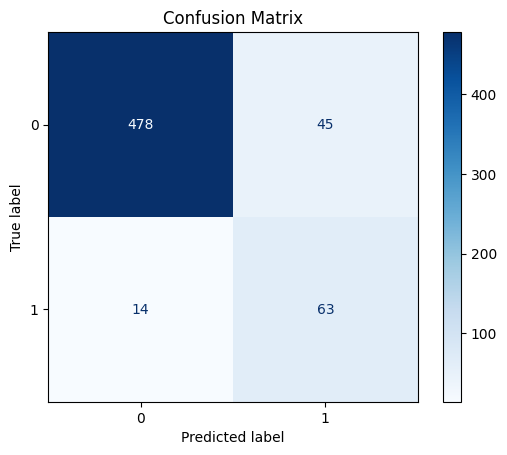

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

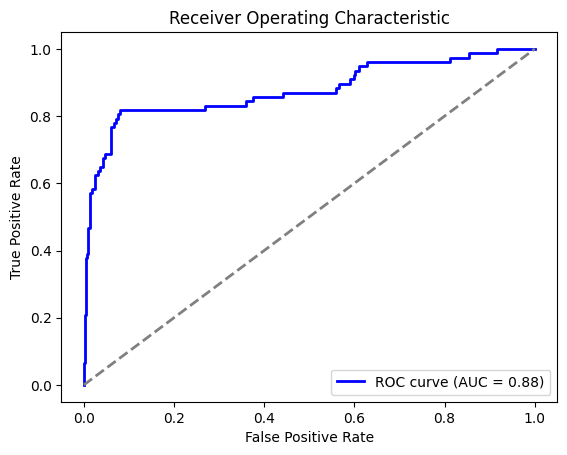

In [28]:
# ROC curve and AUC
fpr, tpr, _ = roc_curve(dev_labels.ravel(), dev_results.predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [29]:
# Print metrics for each class
precision, recall, f1, _ = precision_recall_fscore_support(
    dev_labels, predictions, average=None
)
accuracy = accuracy_score(dev_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
for i, label in enumerate(emotion_labels):
    print(f"{label}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

Accuracy: 0.5300
anger: Precision=0.7222, Recall=0.8125, F1=0.7647
disgust: Precision=0.4444, Recall=0.8000, F1=0.5714
fear: Precision=0.7222, Recall=0.9286, F1=0.8125
joy: Precision=0.4545, Recall=0.9091, F1=0.6061
sadness: Precision=0.6250, Recall=0.5882, F1=0.6061
surprise: Precision=0.5625, Recall=1.0000, F1=0.7200


In [32]:
# Predict on test set
test_encodings = tokenizer(list(test_hin['text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_hin), 6)))  # Dummy labels for test
test_results = trainer.predict(test_dataset)
test_predictions = (torch.sigmoid(torch.tensor(test_results.predictions)) > 0.1).numpy()

In [34]:
# Save predictions
test_hin[emotion_labels] = test_predictions
test_hin.to_csv('test_predictions_hin_mbert_base_cased_v1.csv', index=False)

# Twitter XLM RoBERTa Base Sentiment

In [12]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment',
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results/hin/twitter-xlm-roberta-base-sentiment-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [23]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [24]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.181500,0.177997,0.590000,0.719246,0.648287,0.818182
1000,0.084100,0.176201,0.710000,0.756690,0.738102,0.792208
1500,0.048400,0.207171,0.690000,0.748623,0.716655,0.805195
2000,0.030400,0.215475,0.670000,0.740685,0.684562,0.818182
2500,0.018300,0.197338,0.710000,0.765445,0.725806,0.818182
3000,0.011700,0.219845,0.730000,0.792758,0.762500,0.831169
3500,0.008500,0.261212,0.700000,0.754218,0.719126,0.805195
4000,0.005600,0.249770,0.740000,0.790656,0.780978,0.805195
4500,0.004600,0.265865,0.750000,0.785251,0.774665,0.805195
5000,0.003200,0.276006,0.720000,0.774482,0.739448,0.818182


In [25]:
best_threshold, final_metrics = evaluate_on_validation_set(trainer)
print(f"Optimal Threshold: {best_threshold}")
print(f"Final Metrics: {final_metrics}")

metrics: {'accuracy': 0.61, 'f1': 0.7150049135695069, 'precision': 0.6394838365968397, 'recall': 0.8311688311688312}
metrics: {'accuracy': 0.68, 'f1': 0.754650913267439, 'precision': 0.7131511630315459, 'recall': 0.8181818181818182}
metrics: {'accuracy': 0.71, 'f1': 0.756689584924879, 'precision': 0.7381022656996683, 'recall': 0.7922077922077922}
metrics: {'accuracy': 0.72, 'f1': 0.7523172905525848, 'precision': 0.7411081883484482, 'recall': 0.7792207792207793}
metrics: {'accuracy': 0.72, 'f1': 0.72727433769052, 'precision': 0.7408598606906878, 'recall': 0.7272727272727273}
metrics: {'accuracy': 0.75, 'f1': 0.7556053982791989, 'precision': 0.8139816532673676, 'recall': 0.7272727272727273}
metrics: {'accuracy': 0.76, 'f1': 0.7653182276924893, 'precision': 0.8476799810833424, 'recall': 0.7272727272727273}
metrics: {'accuracy': 0.77, 'f1': 0.7749185385550722, 'precision': 0.8650278293135436, 'recall': 0.7272727272727273}
metrics: {'accuracy': 0.74, 'f1': 0.7421455346332195, 'precision': 0

In [26]:
# Evaluate on dev set
dev_results = trainer.predict(dev_dataset)

# Plot confusion matrix
predictions = (torch.sigmoid(torch.tensor(dev_results.predictions)) > 0.8).numpy()
conf_matrix = confusion_matrix(dev_labels.ravel(), predictions.ravel())

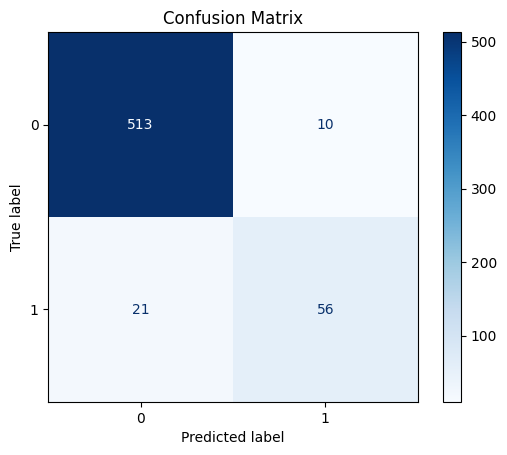

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

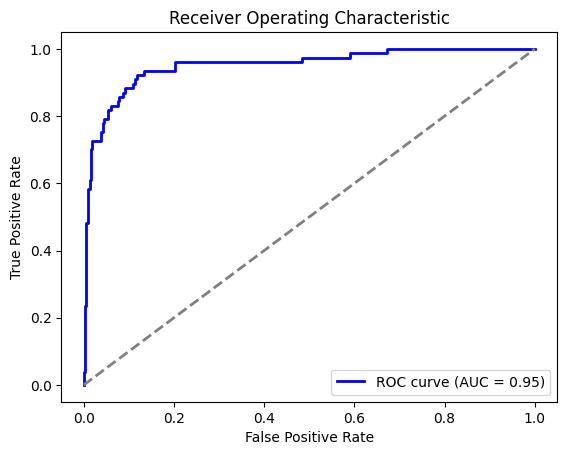

In [28]:
# ROC curve and AUC
fpr, tpr, _ = roc_curve(dev_labels.ravel(), dev_results.predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [29]:
# Print metrics for each class
precision, recall, f1, _ = precision_recall_fscore_support(
    dev_labels, predictions, average=None
)
accuracy = accuracy_score(dev_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
for i, label in enumerate(emotion_labels):
    print(f"{label}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

Accuracy: 0.7700
anger: Precision=1.0000, Recall=0.8125, F1=0.8966
disgust: Precision=1.0000, Recall=0.4000, F1=0.5714
fear: Precision=0.8125, Recall=0.9286, F1=0.8667
joy: Precision=0.7273, Recall=0.7273, F1=0.7273
sadness: Precision=0.7857, Recall=0.6471, F1=0.7097
surprise: Precision=0.8750, Recall=0.7778, F1=0.8235


In [30]:
test_encodings = tokenizer(list(test_hin['text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_hin), 6)))  # Dummy labels for test
test_results = trainer.predict(test_dataset)
test_predictions = (torch.sigmoid(torch.tensor(test_results.predictions)) > 0.8).numpy()

test_hin[emotion_labels] = test_predictions
test_hin.to_csv('test_predictions_hin_twitter_xlm_roberta_base_sentiment_v1.csv', index=False)

# XLM RoBERTa Base

In [40]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/xlm-roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('FacebookAI/xlm-roberta-base',
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results/hin/xlm-roberta-base-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [42]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [43]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.301400,0.235027,0.470000,0.611330,0.538601,0.740260
1000,0.139900,0.160814,0.700000,0.777476,0.737337,0.844156
1500,0.085700,0.138974,0.760000,0.806014,0.790785,0.831169
2000,0.054100,0.154382,0.730000,0.793372,0.747264,0.857143
2500,0.038000,0.185786,0.720000,0.785346,0.750381,0.831169
3000,0.025300,0.225227,0.710000,0.771402,0.734126,0.818182
3500,0.015700,0.238129,0.710000,0.783806,0.739482,0.844156
4000,0.011700,0.241674,0.720000,0.786398,0.737360,0.844156
4500,0.006600,0.254477,0.700000,0.783185,0.713956,0.870130
5000,0.005200,0.226031,0.740000,0.820786,0.757753,0.896104


In [44]:
best_threshold, final_metrics = evaluate_on_validation_set(trainer)
print(f"Optimal Threshold: {best_threshold}")
print(f"Final Metrics: {final_metrics}")

metrics: {'accuracy': 0.69, 'f1': 0.7626640026640027, 'precision': 0.6656265812109968, 'recall': 0.8961038961038961}
metrics: {'accuracy': 0.75, 'f1': 0.7978270647101816, 'precision': 0.751616565252929, 'recall': 0.8571428571428571}
metrics: {'accuracy': 0.76, 'f1': 0.8060135508683961, 'precision': 0.7907854050711194, 'recall': 0.8311688311688312}
metrics: {'accuracy': 0.76, 'f1': 0.8110312604315603, 'precision': 0.8018243661100805, 'recall': 0.8311688311688312}
metrics: {'accuracy': 0.78, 'f1': 0.808181691121185, 'precision': 0.8442176870748299, 'recall': 0.7922077922077922}
metrics: {'accuracy': 0.78, 'f1': 0.804534541089163, 'precision': 0.8521811521811522, 'recall': 0.7792207792207793}
metrics: {'accuracy': 0.78, 'f1': 0.7982653876597662, 'precision': 0.8767676767676768, 'recall': 0.7532467532467533}
metrics: {'accuracy': 0.78, 'f1': 0.7836049780413733, 'precision': 0.883982683982684, 'recall': 0.7272727272727273}
metrics: {'accuracy': 0.76, 'f1': 0.7514586695922387, 'precision': 0

In [45]:
# Evaluate on dev set
dev_results = trainer.predict(dev_dataset)

# Plot confusion matrix
predictions = (torch.sigmoid(torch.tensor(dev_results.predictions)) > 0.4).numpy()
conf_matrix = confusion_matrix(dev_labels.ravel(), predictions.ravel())

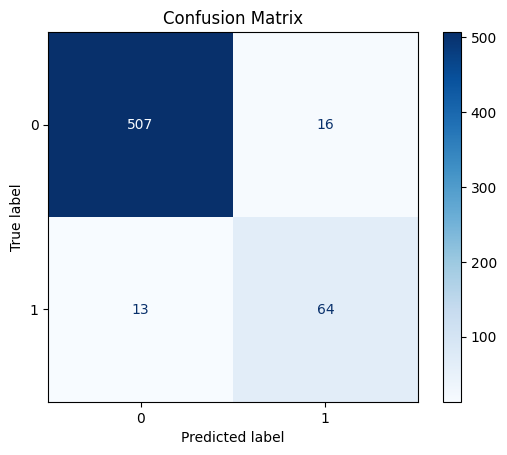

In [46]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

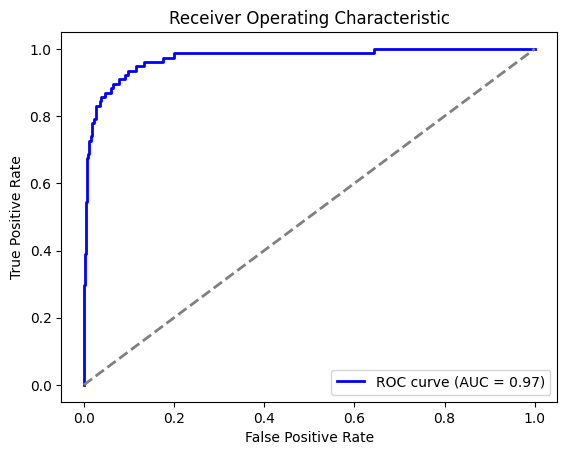

In [47]:
# ROC curve and AUC
fpr, tpr, _ = roc_curve(dev_labels.ravel(), dev_results.predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [48]:
# Print metrics for each class
precision, recall, f1, _ = precision_recall_fscore_support(
    dev_labels, predictions, average=None
)
accuracy = accuracy_score(dev_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
for i, label in enumerate(emotion_labels):
    print(f"{label}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

Accuracy: 0.7600
anger: Precision=0.7619, Recall=1.0000, F1=0.8649
disgust: Precision=0.7500, Recall=0.6000, F1=0.6667
fear: Precision=0.8000, Recall=0.8571, F1=0.8276
joy: Precision=0.7500, Recall=0.8182, F1=0.7826
sadness: Precision=0.8000, Recall=0.7059, F1=0.7500
surprise: Precision=1.0000, Recall=1.0000, F1=1.0000


In [49]:
test_encodings = tokenizer(list(test_hin['text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_hin), 6)))  # Dummy labels for test
test_results = trainer.predict(test_dataset)
test_predictions = (torch.sigmoid(torch.tensor(test_results.predictions)) > 0.4).numpy()

test_hin[emotion_labels] = test_predictions
test_hin.to_csv('test_predictions_xlm_roberta_base_v1.csv', index=False)